In [1]:
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
import seaborn as sns
import os

from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

In [2]:
excel_path = 'D:/Studia/0. SGH/Semestr 3/Uczenie Maszynowe i SI w finansach/Projekt/histimpl.xls'
sheet_name = 'Historical Impl Premiums'
start_row = 6 

# Wczytanie danych
df = pd.read_excel(excel_path, sheet_name, header=start_row)

In [3]:
df

,Year,Earnings Yield,Dividend Yield,S&P 500,Earnings*,Dividends*,Dividends + Buybacks,Change in Earnings,Change in Dividends,T.Bill Rate,T.Bond Rate,Bond-Bill,Smoothed Growth,Implied Premium (DDM),Analyst Growth Estimate,Implied ERP (FCFE),Implied Premium (FCFE with sustainable Payout),ERP/Riskfree Rate
0,1960,0.053400,0.034100,58.11,3.103074,1.981551,NaN,NaN,NaN,0.0266,0.0276,0.0010,0.024484,NaN,NaN,NaN,NaN,NaN
1,1961,0.047100,0.028500,71.55,3.370005,2.039175,NaN,0.086021,0.029080,0.0213,0.0235,0.0022,0.024051,0.0292,NaN,0.0292,NaN,1.242553
2,1962,0.058100,0.034000,63.10,3.666110,2.145400,NaN,0.087865,0.052092,0.0273,0.0385,0.0112,0.040496,0.0356,NaN,0.0356,NaN,0.924675
3,1963,0.055100,0.031300,75.02,4.133602,2.348126,NaN,0.127517,0.094493,0.0312,0.0414,0.0102,0.049635,0.0338,NaN,0.0338,NaN,0.816425
4,1964,0.056200,0.030500,84.75,4.762950,2.584875,NaN,0.152252,0.100825,0.0354,0.0421,0.0067,0.051323,0.0331,NaN,0.0331,NaN,0.786223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2019,0.050251,0.018200,3230.78,162.350000,58.800000,150.50,0.094445,0.096810,0.0155,0.0192,0.0037,0.025654,0.0203,0.0396,0.0520,0.0506,2.708333
60,2020,0.037209,0.015096,3756.07,139.760000,56.700000,127.78,-0.139144,-0.035714,0.0009,0.0093,0.0084,0.007352,0.0165,0.0542,0.0472,0.0494,5.075269
61,2021,0.043301,0.012421,4766.18,206.380000,59.200000,147.24,0.476674,0.044092,0.0006,0.0151,0.0145,0.017052,0.0172,0.0647,0.0424,0.0490,2.807947
62,2022,0.057166,0.017799,3839.50,219.490000,68.340000,181.99,0.063524,0.154392,0.0442,0.0388,-0.0054,0.055874,0.0216,0.0641,0.0594,0.0511,1.530928


In [4]:
# usuwanie kolumn z brakami
df.drop('Implied Premium (FCFE with sustainable Payout)', axis = 1, inplace = True)
df.drop('Dividends + Buybacks', axis = 1, inplace = True)
df.drop('Analyst Growth Estimate', axis = 1, inplace = True)

df.drop(index = 0, axis = 2, inplace = True)

In [5]:
df.shape

(63, 15)

In [6]:
df.isnull().sum()

Year                     0
Earnings Yield           0
Dividend Yield           0
S&P 500                  0
Earnings*                0
Dividends*               0
Change in Earnings       0
Change in Dividends      0
T.Bill Rate              0
T.Bond Rate              0
Bond-Bill                0
Smoothed Growth          0
Implied Premium (DDM)    0
Implied ERP (FCFE)       0
ERP/Riskfree Rate        0
dtype: int64

In [7]:
df.describe()

,Year,Earnings Yield,Dividend Yield,S&P 500,Earnings*,Dividends*,Change in Earnings,Change in Dividends,T.Bill Rate,T.Bond Rate,Bond-Bill,Smoothed Growth,Implied Premium (DDM),Implied ERP (FCFE),ERP/Riskfree Rate
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,1992.000000,0.064736,0.028748,959.229524,51.055460,18.405353,0.080328,0.060144,0.044937,0.057203,0.012266,0.055872,0.031567,0.042467,1.081531
std,18.330303,0.024273,0.012144,1161.662711,55.653166,18.065089,0.150644,0.064279,0.031951,0.029117,0.012052,0.026415,0.012407,0.011057,0.951473
min,1961.000000,0.030741,0.011374,63.100000,3.370005,2.039175,-0.307857,-0.204635,0.000300,0.009300,-0.013200,0.002782,0.012000,0.020500,0.318323
25%,1976.500000,0.049476,0.018492,105.660000,10.308276,4.541394,0.006187,0.021197,0.019650,0.038450,0.002850,0.035837,0.021800,0.034450,0.486517
50%,1992.000000,0.057300,0.029000,435.710000,24.320000,12.687440,0.081347,0.052617,0.044200,0.055700,0.011900,0.052451,0.029200,0.040800,0.668135
75%,2007.500000,0.072121,0.036350,1288.960000,79.495000,24.085000,0.163717,0.102600,0.062550,0.075800,0.020500,0.073070,0.039750,0.050950,1.160492
max,2023.000000,0.136400,0.055700,4769.830000,219.700000,69.690000,0.504163,0.191853,0.147100,0.139800,0.037000,0.116994,0.064500,0.064500,5.075269


In [8]:
# współczynnik zmienności dla każdej kolumny
cv_result = (df.std() / df.mean()) * 100

# Wyświetl wyniki
print("Współczynnik zmienności:")
print(cv_result)

Współczynnik zmienności:
Year                       0.920196
Earnings Yield            37.496117
Dividend Yield            42.244013
S&P 500                  121.103728
Earnings*                109.005316
Dividends*                98.151279
Change in Earnings       187.537045
Change in Dividends      106.874452
T.Bill Rate               71.101410
T.Bond Rate               50.900856
Bond-Bill                 98.257858
Smoothed Growth           47.276659
Implied Premium (DDM)     39.305629
Implied ERP (FCFE)        26.036910
ERP/Riskfree Rate         87.974633
dtype: float64


<Axes: >

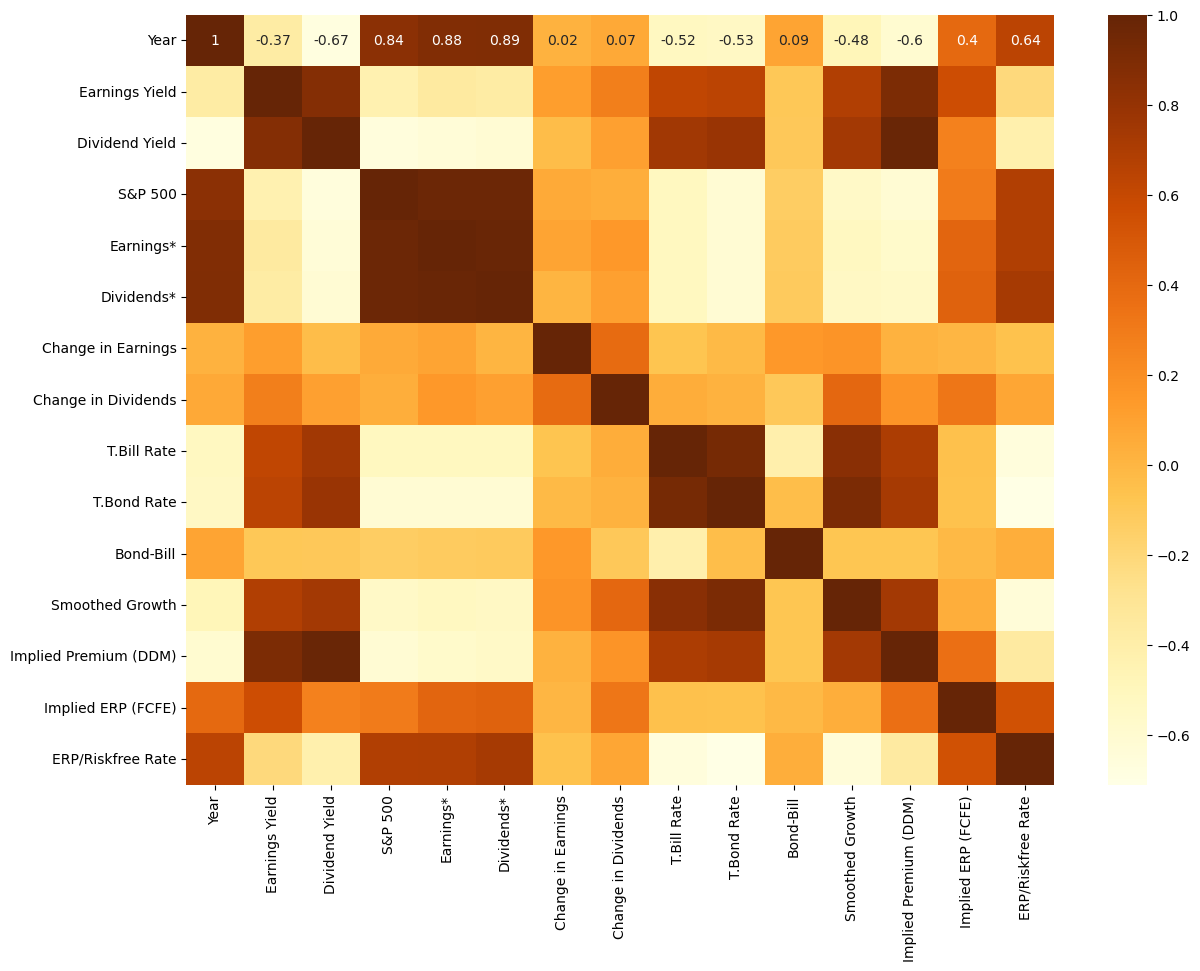

In [9]:
correlation = df.corr().round(2)
plt.figure(figsize = (14,10))
sns.heatmap(correlation, annot = True, cmap = 'YlOrBr')

In [10]:
# zmienne 'change in earnings' i 'change in dividends' są słabo skorelowane ze zmienną objaśnianą
df.drop('Change in Dividends', axis = 1, inplace = True)
df.drop('Change in Earnings', axis = 1, inplace = True)

In [11]:
df_sieci = df.copy()

## lasy losowe - bagging

In [13]:
# Podział zbioru na zbiór uczący i testowy
X = df.drop('ERP/Riskfree Rate', axis=1)
y = df['ERP/Riskfree Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
print("X_train :",X_train.shape)
print("X_test:",X_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

X_train : (50, 12)
X_test: (13, 12)
y_train : (50,)
y_test : (13,)


In [15]:
y_pred = random_forest_100.predict(X_test)

# Ocen jakosci na podstawie błędu średniokwadratowego (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


# R kwadratowy
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Ocen jakość modelu za pomocą Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

NameError: name 'random_forest_100' is not defined

In [16]:
# Wyjaśnij wpływ zmiennych na wynik 'rate'
feature_importances = random_forest_100.feature_importances_
features = X.columns

# Wyświetl ważność zmiennych
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

NameError: name 'random_forest_100' is not defined

In [17]:
# Dokonaj cross-validacji
cv_scores = cross_val_score(random_forest_100, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Neguj wyniki, ponieważ cross_val_score domyślnie zwraca ujemne wartości MSE
cv_scores = -cv_scores

# Wyświetl wyniki cross-validacji
print("Wyniki cross-validacji (neg_mean_squared_error):", cv_scores)
print("Średnia wyników cross-validacji:", cv_scores.mean())

NameError: name 'random_forest_100' is not defined

## xgboost

In [18]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [19]:
# Przewiduj wartości dla zestawu testowego
y_pred = xgb_model.predict(X_test)

# Ocen jakosci na podstawie:
# błędu średniokwadratowego (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# R kwadrat
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.019908431637234398
R-squared: 0.9743714993175487
Mean Absolute Error: 0.09767911911010739


In [20]:
print(y_test)

25    0.43
40    0.56
52    3.28
28    0.41
62    1.53
3     0.82
22    0.47
43    0.87
42    1.08
45    0.93
39    0.32
54    2.66
36    0.50
Name: ERP/Riskfree Rate, dtype: float64


In [21]:
print(y_pred)

[0.45607266 0.57426447 3.0088215  0.4382777  1.2643375  0.8035947
 0.41779462 0.86197674 0.87653565 0.9356914  0.4922612  2.8568761
 0.5094457 ]


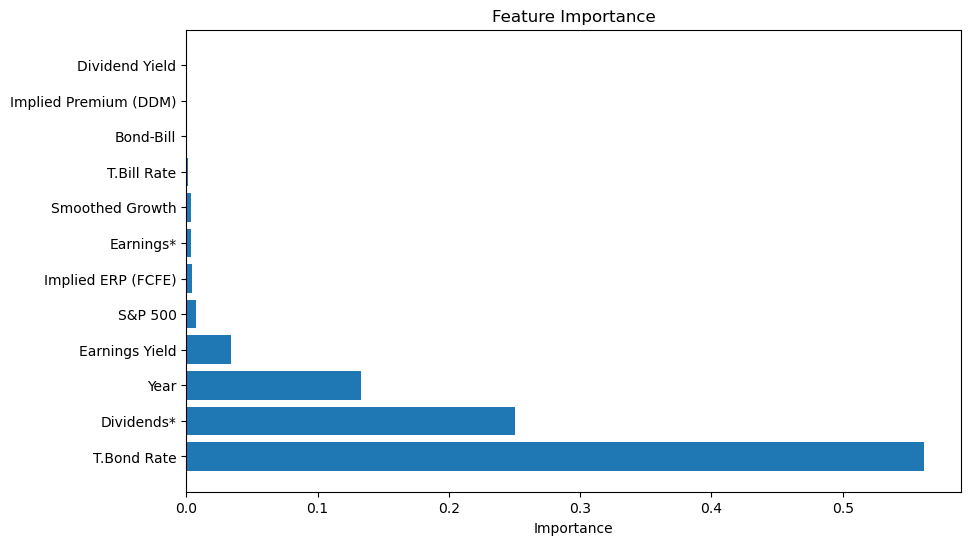

In [22]:
# Wyjaśnij wpływ zmiennych na wynik 'rate'
feature_importances = xgb_model.feature_importances_
features = X.columns

# Wyświetl ważność zmiennych
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [23]:
# Wyznaczenie optymalnych wartości hiperparametrów reg_alpha i reg_lambda

# Tworzymy siatkę hiperparametrów do przetestowania
param_grid = {
    'n_estimators':range(10, 301),
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid,
                           cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

# Wyznaczenie najlepszych wartości hiperparametrów
best_params = grid_search.best_params_
print("Najlepsze wartości hiperparametrów: ", best_params)

Fitting 5 folds for each of 14259 candidates, totalling 71295 fits


KeyboardInterrupt: 

In [90]:
# Konstrukcja modelu XGBoost dla tych otrzymanych hiperparametrów
xgb_model_optimizes = XGBRegressor(objective='reg:squarederror', random_state=1, n_estimators = 237,
                                reg_alpha=1, reg_lambda=100)

# Dopasowanie modelu XGBoost na danych treningowych
xgb_model_optimizes.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=237, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [92]:
# Przewiduj wartości dla zestawu testowego
y_pred = xgb_model_optimizes.predict(X_test)

# Ocen jakosci na podstawie:
# błędu średniokwadratowego (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


# R kwadrat
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.03056550806959974
R-squared: 0.9607981063236265
Mean Absolute Error: 0.1356106115517898


## Sieci neuronowe

In [12]:
df_sieci.head()

,Year,Earnings Yield,Dividend Yield,S&P 500,Earnings*,Dividends*,T.Bill Rate,T.Bond Rate,Bond-Bill,Smoothed Growth,Implied Premium (DDM),Implied ERP (FCFE),ERP/Riskfree Rate
1,1961,0.0471,0.0285,71.55,3.370005,2.039175,0.0213,0.0235,0.0022,0.024051,0.0292,0.0292,1.242553
2,1962,0.0581,0.0340,63.10,3.666110,2.145400,0.0273,0.0385,0.0112,0.040496,0.0356,0.0356,0.924675
3,1963,0.0551,0.0313,75.02,4.133602,2.348126,0.0312,0.0414,0.0102,0.049635,0.0338,0.0338,0.816425
4,1964,0.0562,0.0305,84.75,4.762950,2.584875,0.0354,0.0421,0.0067,0.051323,0.0331,0.0331,0.786223
5,1965,0.0573,0.0306,92.43,5.296239,2.828358,0.0393,0.0465,0.0072,0.054558,0.0332,0.0332,0.713978


In [13]:
X = df_sieci.drop(['ERP/Riskfree Rate'], axis=1).copy()
y = df_sieci['ERP/Riskfree Rate'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
print("X_train :",X_train.shape)
print("X_test:",X_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

X_train : (50, 12)
X_test: (13, 12)
y_train : (50,)
y_test : (13,)


In [15]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [16]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [17]:
seed_value= 123
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
rn.seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)

### Optymalizacja hiperparametrów - epoki, warstwy, neurony

In [18]:
siec1 = Sequential()
siec1.add(Dense(15, input_dim=X_train_scaled.shape[1], activation='relu'))
siec1.add(Dense(1, activation='linear'))
siec1.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

siec1.fit(X_train_scaled, y_train_scaled, epochs=100)


Epoch 1/100


2/2 [==============================] - 1s 10ms/step - loss: 2.3891 - mae: 1.2376
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 2.2791 - mae: 1.2153
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 2.1548 - mae: 1.1905
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 2.0592 - mae: 1.1714
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 1.9618 - mae: 1.1503
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 1.8675 - mae: 1.1297
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7742 - mae: 1.1056
Epoch 8/100
2/2 [==============================] - 0s 7ms/step - loss: 1.7080 - mae: 1.0898
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 1.6292 - mae: 1.0686
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 1.5533 - mae: 1.0482
Epoch 11/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4

In [19]:
# Ocena modelu na danych testowych
mse, mae = siec1.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f'Test loss (MSE): {mse}, Test MAE: {mae}')

1/1 [==============================] - 0s 123ms/step - loss: 0.2615 - mae: 0.3303
Test loss (MSE): 0.26148685812950134, Test MAE: 0.3302542567253113


In [38]:
# Dokonanie predykcji na zbiorze testowym
y_pred = siec1.predict(X_test_scaled)

# Obliczenie R^2
r2 = r2_score(y_test_scaled, y_pred)
print(f'R^2: {r2}')

1/1 [==============================] - 0s 47ms/step
R^2: 0.6915354567822264


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

siec2t = Sequential()
siec2t.add(Dense(15, input_dim=X_train_scaled.shape[1], activation='relu'))
siec2t.add(Dense(1, activation='linear')) 

siec2t.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Trenowanie modelu z EarlyStopping
siec2t.fit(X_train_scaled, y_train_scaled, epochs=150, 
            validation_data=(X_test_scaled, y_test_scaled), 
            callbacks=[early_stopping])


Epoch 1/150
2/2 [==============================] - 1s 152ms/step - loss: 1.1769 - mae: 0.8535 - val_loss: 1.4500 - val_mae: 0.9969
Epoch 2/150
2/2 [==============================] - 0s 44ms/step - loss: 1.1340 - mae: 0.8379 - val_loss: 1.4067 - val_mae: 0.9823
Epoch 3/150
2/2 [==============================] - 0s 49ms/step - loss: 1.0855 - mae: 0.8225 - val_loss: 1.3630 - val_mae: 0.9665
Epoch 4/150
2/2 [==============================] - 0s 59ms/step - loss: 1.0400 - mae: 0.8060 - val_loss: 1.3214 - val_mae: 0.9514
Epoch 5/150
2/2 [==============================] - 0s 45ms/step - loss: 0.9954 - mae: 0.7920 - val_loss: 1.2802 - val_mae: 0.9362
Epoch 6/150
2/2 [==============================] - 0s 42ms/step - loss: 0.9557 - mae: 0.7750 - val_loss: 1.2398 - val_mae: 0.9208
Epoch 7/150
2/2 [==============================] - 0s 51ms/step - loss: 0.9084 - mae: 0.7574 - val_loss: 1.1991 - val_mae: 0.9058
Epoch 8/150
2/2 [==============================] - 0s 66ms/step - loss: 0.8768 - mae: 0.

#### Early stopping na 129 epoch

In [36]:
siec2 = Sequential()
siec2.add(Dense(15, input_dim=X_train_scaled.shape[1], activation='relu'))
siec2.add(Dense(1, activation='linear'))
siec2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

siec2.fit(X_train_scaled, y_train_scaled, epochs=125)

Epoch 1/125
2/2 [==============================] - 0s 5ms/step - loss: 1.1281 - mae: 0.7706
Epoch 2/125
2/2 [==============================] - 0s 7ms/step - loss: 1.0546 - mae: 0.7426
Epoch 3/125
2/2 [==============================] - 0s 8ms/step - loss: 0.9810 - mae: 0.7170
Epoch 4/125
2/2 [==============================] - 0s 8ms/step - loss: 0.9204 - mae: 0.6939
Epoch 5/125
2/2 [==============================] - 0s 8ms/step - loss: 0.8603 - mae: 0.6702
Epoch 6/125
2/2 [==============================] - 0s 7ms/step - loss: 0.8071 - mae: 0.6485
Epoch 7/125
2/2 [==============================] - 0s 5ms/step - loss: 0.7499 - mae: 0.6242
Epoch 8/125
2/2 [==============================] - 0s 6ms/step - loss: 0.7100 - mae: 0.6062
Epoch 9/125
2/2 [==============================] - 0s 7ms/step - loss: 0.6696 - mae: 0.5868
Epoch 10/125
2/2 [==============================] - 0s 7ms/step - loss: 0.6246 - mae: 0.5663
Epoch 11/125
2/2 [==============================] - 0s 6ms/step - loss: 0.5943 

In [37]:
# Ocena modelu na danych testowych
mse, mae = siec2.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f'Test loss (MSE): {mse}, Test MAE: {mae}')

1/1 [==============================] - 0s 106ms/step - loss: 0.1827 - mae: 0.2965
Test loss (MSE): 0.18267320096492767, Test MAE: 0.2964540719985962


In [39]:
# Dokonanie predykcji na zbiorze testowym
y_pred = siec2.predict(X_test_scaled)

# Obliczenie R^2
r2 = r2_score(y_test_scaled, y_pred)
print(f'R^2: {r2}')

1/1 [==============================] - 0s 53ms/step
R^2: 0.7845084582917252


In [23]:
checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', 
                             save_best_only=True, mode='min', verbose=1)

siec3 = Sequential()
siec3.add(Dense(15, input_dim=X_train_scaled.shape[1], activation='relu'))
siec3.add(Dense(1, activation='linear'))

siec3.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=['mae', 'mse'])

siec3.fit(X_train_scaled, y_train_scaled, epochs=150, 
          validation_data=(X_test_scaled, y_test_scaled), callbacks=[checkpoint])


Epoch 1/150
1/2 [==============>...............] - ETA: 0s - loss: 1.0462 - mae: 0.8375 - mse: 1.0462
Epoch 1: val_loss improved from inf to 1.86391, saving model to best_model.keras
2/2 [==============================] - 1s 198ms/step - loss: 1.3853 - mae: 0.9332 - mse: 1.3853 - val_loss: 1.8639 - val_mae: 1.1525 - val_mse: 1.8639
Epoch 2/150
1/2 [==============>...............] - ETA: 0s - loss: 1.6560 - mae: 1.0219 - mse: 1.6560
Epoch 2: val_loss improved from 1.86391 to 1.81219, saving model to best_model.keras
2/2 [==============================] - 0s 60ms/step - loss: 1.3262 - mae: 0.9074 - mse: 1.3262 - val_loss: 1.8122 - val_mae: 1.1379 - val_mse: 1.8122
Epoch 3/150
1/2 [==============>...............] - ETA: 0s - loss: 1.4983 - mae: 0.9866 - mse: 1.4983
Epoch 3: val_loss improved from 1.81219 to 1.76118, saving model to best_model.keras
2/2 [==============================] - 0s 62ms/step - loss: 1.2682 - mae: 0.8820 - mse: 1.2682 - val_loss: 1.7612 - val_mae: 1.1223 - val_mse:

In [24]:
siec3 = load_model('best_model.keras')

# Ocena modelu na danych testowych
loss, mae, mse = siec3.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f'Test MSE: {mse}, Test MAE: {mae}')

1/1 [==============================] - 0s 174ms/step - loss: 0.1789 - mae: 0.2753 - mse: 0.1789
Test MSE: 0.1788608431816101, Test MAE: 0.2752821743488312


In [40]:
# Dokonanie predykcji na zbiorze testowym
y_pred = siec3.predict(X_test_scaled)

# Obliczenie R^2
r2 = r2_score(y_test_scaled, y_pred)
print(f'R^2: {r2}')

1/1 [==============================] - 0s 47ms/step
R^2: 0.7890057116486244


#### Najlepsze wartości mse i mae dla sieci z 150 epokami

In [26]:
def create_model(neurons=1, hidden_layers=1):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    for _ in range(1, hidden_layers):
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

In [27]:
# Zdefiniowanie modelu dla KerasRegressor
model = KerasRegressor(model=create_model, epochs=100, verbose=0)

# Zdefiniowanie zakresu parametrów do przetestowania
param_grid = {
    'model__neurons': [10, 15, 20, 25, 30],
    'model__hidden_layers': [1, 2, 3, 4]
}

In [28]:
# Wywołanie obiektu klasy GridSearchCV i przeprowadzenie walidacji krzyżowej
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train_scaled, y_train_scaled)

In [29]:
print("Najlepszy wynik: %f, uzyskany dla parametrów: %s" 
      % (grid_result.best_score_, grid_result.best_params_))

Najlepszy wynik: -0.225319, uzyskany dla parametrów: {'model__hidden_layers': 4, 'model__neurons': 30}


In [30]:
grid_result.cv_results_

{'mean_fit_time': array([0.95365334, 0.94472583, 0.95032668, 0.94413153, 1.01621779,
        1.08441059, 1.08739249, 1.09430552, 1.08501824, 1.14221358,
        1.32278736, 1.23518769, 1.25740091, 1.23792609, 1.22893937,
        1.47573543, 1.40221206, 1.38072316, 1.3943375 , 1.41041732]),
 'std_fit_time': array([0.00530633, 0.01225581, 0.00412481, 0.00456867, 0.09739884,
        0.00615138, 0.00526179, 0.01171558, 0.0059764 , 0.03412194,
        0.12915512, 0.00850949, 0.00207823, 0.00827257, 0.00191725,
        0.15246504, 0.04428833, 0.00351049, 0.02577569, 0.01445456]),
 'mean_score_time': array([0.09641727, 0.08534551, 0.08409468, 0.08299112, 0.08794451,
        0.08929753, 0.08849025, 0.09256808, 0.08988285, 0.09303133,
        0.09644095, 0.0964032 , 0.10784626, 0.09585309, 0.09751495,
        0.10347676, 0.11438711, 0.10556634, 0.10277883, 0.10202893]),
 'std_score_time': array([0.014968  , 0.0009781 , 0.00075195, 0.00155306, 0.00679565,
        0.00175327, 0.00051185, 0.002482

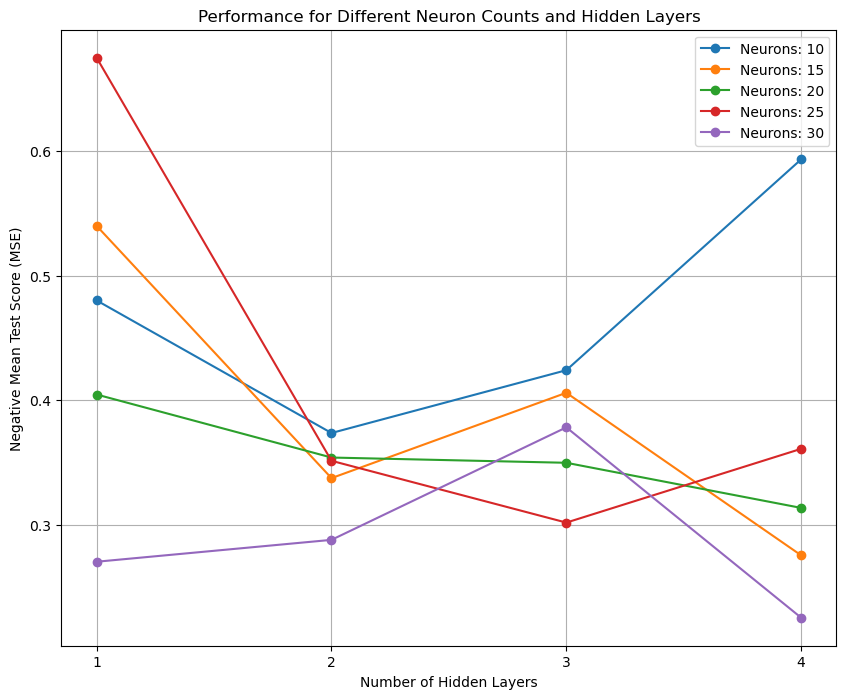

In [35]:
# Aktualizacja danych do wykresu na podstawie nowych wyników
data = {
    'mean_fit_time': np.array([0.95365334, 0.94472583, 0.95032668, 0.94413153, 1.01621779,
        1.08441059, 1.08739249, 1.09430552, 1.08501824, 1.14221358,
        1.32278736, 1.23518769, 1.25740091, 1.23792609, 1.22893937,
        1.47573543, 1.40221206, 1.38072316, 1.3943375 , 1.41041732]),
    'param_model__hidden_layers': np.array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]),
    'param_model__neurons': np.array([10, 15, 20, 25, 30, 10, 15, 20, 25, 30, 10, 15, 20, 25, 30, 10, 15, 20, 25, 30]),
    'mean_test_score': np.array([-0.48005311, -0.53991769, -0.40452138, -0.67491597, -0.27026699,
        -0.37361269, -0.33739498, -0.35392183, -0.35130378, -0.28782696,
        -0.42404567, -0.40591325, -0.34971276, -0.30168919, -0.37815086,
        -0.59332834, -0.27539751, -0.31348161, -0.36092014, -0.22531892])
}

# Przygotowanie danych do wykresu
unique_hidden_layers = np.unique(data['param_model__hidden_layers'])
unique_neurons = np.unique(data['param_model__neurons'])

# Mapowanie wyników do macierzy dla wizualizacji
scores_matrix = np.zeros((len(unique_neurons), len(unique_hidden_layers)))

for i, neuron_count in enumerate(unique_neurons):
    for j, layer_count in enumerate(unique_hidden_layers):
        # Wyszukanie i przypisanie odpowiedniego wyniku do macierzy
        idx = np.where((data['param_model__neurons'] == neuron_count) & (data['param_model__hidden_layers'] == layer_count))
        scores_matrix[i, j] = -data['mean_test_score'][idx]  # Zmiana znaku, aby lepiej pasowało do oczekiwań (im mniejszy MSE, tym lepiej)

# Tworzenie wykresu
plt.figure(figsize=(10, 8))
for idx, neuron_count in enumerate(unique_neurons):
    plt.plot(unique_hidden_layers, scores_matrix[idx, :], marker='o', label=f'Neurons: {neuron_count}')

plt.xlabel('Number of Hidden Layers')
plt.ylabel('Negative Mean Test Score (MSE)')
plt.title('Performance for Different Neuron Counts and Hidden Layers')
plt.legend()
plt.grid(True)
plt.xticks(unique_hidden_layers)  # Set x-ticks to be the hidden layers
plt.show()

#### Na podstawie wykresu wybieram 30 neuronów i 4 warstwy ukryte

In [46]:
siec4 = Sequential()
siec4.add(Dense(30, input_dim=X_train_scaled.shape[1], activation='relu'))
siec4.add(Dense(30, activation='relu'))
siec4.add(Dense(30, activation='relu'))
siec4.add(Dense(30, activation='relu'))
siec4.add(Dense(1, activation='linear'))
siec4.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

siec4.fit(X_train_scaled, y_train_scaled, epochs=150)

Epoch 1/150
2/2 [==============================] - 1s 6ms/step - loss: 1.0241 - mae: 0.7115
Epoch 2/150
2/2 [==============================] - 0s 9ms/step - loss: 0.9586 - mae: 0.6821
Epoch 3/150
2/2 [==============================] - 0s 9ms/step - loss: 0.8807 - mae: 0.6494
Epoch 4/150
2/2 [==============================] - 0s 8ms/step - loss: 0.8168 - mae: 0.6246
Epoch 5/150
2/2 [==============================] - 0s 8ms/step - loss: 0.7624 - mae: 0.6081
Epoch 6/150
2/2 [==============================] - 0s 10ms/step - loss: 0.7151 - mae: 0.5881
Epoch 7/150
2/2 [==============================] - 0s 8ms/step - loss: 0.6558 - mae: 0.5646
Epoch 8/150
2/2 [==============================] - 0s 9ms/step - loss: 0.6172 - mae: 0.5446
Epoch 9/150
2/2 [==============================] - 0s 7ms/step - loss: 0.5690 - mae: 0.5203
Epoch 10/150
2/2 [==============================] - 0s 5ms/step - loss: 0.5187 - mae: 0.4941
Epoch 11/150
2/2 [==============================] - 0s 6ms/step - loss: 0.4802

In [47]:
# Ocena modelu na danych testowych
mse, mae = siec4.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f'Test loss (MSE): {mse}, Test MAE: {mae}')

1/1 [==============================] - 0s 120ms/step - loss: 0.0138 - mae: 0.0907
Test loss (MSE): 0.013800431042909622, Test MAE: 0.09068050980567932


In [48]:
# Dokonanie predykcji na zbiorze testowym
y_pred = siec4.predict(X_test_scaled)

# Obliczenie R^2
r2 = r2_score(y_test_scaled, y_pred)
print(f'R^2: {r2}')

1/1 [==============================] - 0s 66ms/step
R^2: 0.9837202357359027
